In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import pandas as pd

# Define the base image directory
base_dir = '/content/drive/MyDrive/Potato/'

# Folder to score mapping
folder_score_map = {
    'Potato___Early_Blight': 6,
    'Potato___Healthy': 10,
    'Potato___Late_Blight': 4
}

# Collect image paths and scores
data = []
for folder, score in folder_score_map.items():
    folder_path = os.path.join(base_dir, folder)
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            relative_path = os.path.join(folder, fname)
            data.append({'image_path': relative_path, 'score': score})


df = pd.DataFrame(data)


df = df.sort_values(by='image_path')

# Save to CSV
csv_path = '/content/drive/MyDrive/Potato/leaf_scores.csv'
df.to_csv(csv_path, index=False)

print(f" CSV created with {len(df)} entries at: {csv_path}")


 CSV created with 2152 entries at: /content/drive/MyDrive/Potato/leaf_scores.csv


In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms

class LeafHealthScoreDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row['image_path'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        score = torch.tensor(row['score'], dtype=torch.float32)
        return image, score


In [4]:
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

csv_path = '/content/drive/MyDrive/Potato/leaf_scores.csv'
image_dir = '/content/drive/MyDrive/Potato'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

full_dataset = LeafHealthScoreDataset(csv_path, image_dir, transform=transform)

# Split 80/20
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [5]:
from torchvision import models
import torch.nn as nn

class ResNetRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet50(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 1)

    def forward(self, x):
        return self.base_model(x).squeeze(1)

In [6]:
import torch.nn.functional as F
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetRegressor().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for images, scores in train_loader:
        images, scores = images.to(device), scores.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, scores)   # MSELoss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    val_mae = 0
    with torch.no_grad():
        for images, scores in val_loader:
            images, scores = images.to(device), scores.to(device)
            outputs = model(images)
            loss = criterion(outputs, scores)   # MSE
            val_loss += loss.item()

            mae = torch.mean(torch.abs(outputs - scores))   # MAE
            val_mae += mae.item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_mae = val_mae / len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val MAE: {avg_val_mae:.4f}")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


Epoch 1, Train Loss: 4.0948, Val Loss: 0.8415, Val MAE: 0.6818
Epoch 2, Train Loss: 0.3024, Val Loss: 0.1234, Val MAE: 0.2253
Epoch 3, Train Loss: 0.2532, Val Loss: 0.0764, Val MAE: 0.1901
Epoch 4, Train Loss: 0.1243, Val Loss: 0.0361, Val MAE: 0.1276
Epoch 5, Train Loss: 0.1310, Val Loss: 0.0657, Val MAE: 0.1218
Epoch 6, Train Loss: 0.0520, Val Loss: 0.0412, Val MAE: 0.1278
Epoch 7, Train Loss: 0.0422, Val Loss: 0.0119, Val MAE: 0.0786
Epoch 8, Train Loss: 0.0183, Val Loss: 0.0113, Val MAE: 0.0669
Epoch 9, Train Loss: 0.0303, Val Loss: 0.0860, Val MAE: 0.1198
Epoch 10, Train Loss: 0.2839, Val Loss: 0.4227, Val MAE: 0.5473


In [7]:
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [8]:
import torch
import os

def predict_leaf_health(model, image_path, transform, device):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        score = output.item()
    return round(score, 2)


In [9]:
class LeafHealthScoreDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.data.iloc[idx, 0])
        label = torch.tensor(self.data.iloc[idx, 1], dtype=torch.float32)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label, img_path


In [10]:
model.eval()
predictions = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()

        for j in range(len(outputs)):
            # Get the global index in the original dataset
            global_idx = val_loader.dataset.indices[batch_idx * val_loader.batch_size + j]


            fname = val_loader.dataset.dataset.data.iloc[global_idx, 0]

            pred_score = outputs[j].item()
            true_score = labels[j].item()
            predictions.append((fname, pred_score, true_score))

# Print a few results
for fname, pred, true in predictions[:15]:
    print(f"{fname:30s} ➜ Predicted: {pred:.2f}, True: {true:.2f}")


Potato___Early_Blight/d06681cc-3ed1-4af2-ae40-2597eaea3dd4___RS_Early.B 8691.JPG ➜ Predicted: 5.88, True: 6.00
Potato___Late_Blight/77e2a857-e169-42f4-9886-708024781837___RS_LB 4705.JPG ➜ Predicted: 4.74, True: 4.00
Potato___Early_Blight/e4bd2479-dd2f-41ce-9544-4f1804c4ab8b___RS_Early.B 8601.JPG ➜ Predicted: 5.83, True: 6.00
Potato___Late_Blight/b340ff00-3d44-4394-90c5-797dc39f8389___RS_LB 4953.JPG ➜ Predicted: 4.63, True: 4.00
Potato___Early_Blight/32c3bd85-3b12-4051-9185-12d39caaf94f___RS_Early.B 6684.JPG ➜ Predicted: 5.94, True: 6.00
Potato___Early_Blight/52fb5725-33cf-4076-9abc-93311d027da2___RS_Early.B 8415.JPG ➜ Predicted: 5.79, True: 6.00
Potato___Early_Blight/4019e40b-0175-462a-b6bb-228cf42c1a65___RS_Early.B 8256.JPG ➜ Predicted: 5.86, True: 6.00
Potato___Early_Blight/51e028c1-7aec-46e9-a389-391bc38b46f3___RS_Early.B 8505.JPG ➜ Predicted: 5.87, True: 6.00
Potato___Early_Blight/d4f3066f-adb8-401b-a27f-19a12c336ebe___RS_Early.B 8626.JPG ➜ Predicted: 5.59, True: 6.00
Potato___Earl

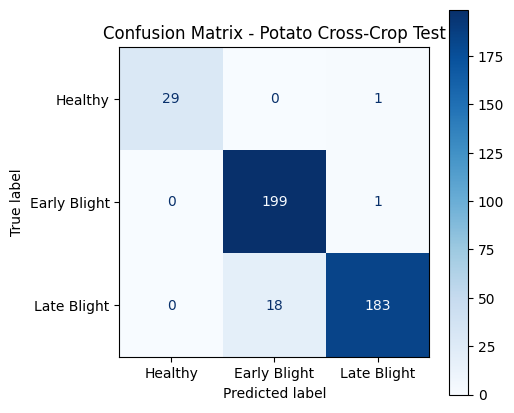

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Define binning function
def bin_score(score):
    if score >= 9:
        return 0  # Healthy
    elif 5 <= score < 7.5:
        return 1  # Early Blight
    elif 3 <= score < 5:
        return 2  # Late Blight
    else:
        return 2  # default to Late Blight if lower

# Map true and predicted scores into categories
y_true = [bin_score(true) for _, _, true in predictions]
y_pred = [bin_score(pred) for _, pred, _ in predictions]

# Class names
class_names = ["Healthy", "Early Blight", "Late Blight"]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(cmap="Blues", ax=ax, values_format="d")
plt.title("Confusion Matrix - Potato Cross-Crop Test")
plt.show()
